In [432]:
%load_ext autoreload
%autoreload 

import os 
import shutil
import numpy as n
from datetime import date
from matplotlib import pyplot as plt
import time
import napari

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [433]:
os.chdir('/home/ali/packages/s2p-lbm/')

from suite3d.job import Job
from suite3d import lbmio, utils, ui
from suite3d.io import get_tif_tag
from suite3d.io import tiff_utils as tfu
from suite3d import file_utils as flu

from suite3d import nbtools as nbui

In [434]:
subjects_dir =   '/mnt/zortex-subjects/'
expt_info = { 
    'subject':         'SS003',
    'date' :          '2024-08-15',
    'expnum' :         [1,2,3,4],}

original_tifs, si_params, exp_str = flu.find_exp(subjects_dir, **expt_info, verbose=False, get_si_params=False)
fixed_tif_dir = '/mnt/md0/runs/s3d-SS003_2024-08-15_1-2-3-4/raw'

In [440]:
import tifffile

In [446]:
# # hacky way to fix the offsets in tiffs
# n_planes_in_tif = 7
# keep_planes = n.array([2,3,4,5,6])
# full_mov = []
# raw_mov = []
# for exp in expt_info['expnum']:
#     leftover_frames = None
#     tifs = flu.find_exp(subjects_dir,expt_info['subject'], expt_info['date'], [exp], verbose=False, get_si_params=False)[0]
#     print(tifs[0])
#     for idx,tif_path in enumerate(tifs):
#         dir_name = tif_path.split(os.path.sep)[-2]
#         tif_name = tif_path.split(os.path.sep)[-1]
#         savedir = os.path.join(fixed_tif_dir, dir_name)
#         os.makedirs(savedir,exist_ok=True)
#         # if dir_name != '1':
#             # break
#         mov = tifffile.imread(tif_path)
#         raw_mov.append(mov)
#         print(f"Loaded tiff with {mov.shape[0]} frames: {dir_name}/{tif_name}")
#         if leftover_frames is not None:
#             mov = n.concatenate([leftover_frames, mov], axis=0)
#             print(f"  concatenated with {leftover_frames.shape[0]} frames for a total of {mov.shape[0]} frames")
#         nf, ny, nx = mov.shape
#         n_full_frames = nf // n_planes_in_tif
#         n_full_frame_planes = n_full_frames * n_planes_in_tif
    
#         leftover_planes = nf % n_planes_in_tif
    
#         full_frame_planes = mov[:n_full_frame_planes]
#         full_frames = mov[:n_full_frame_planes].reshape(n_full_frames, n_planes_in_tif, ny, nx)
#         leftover_frames = mov[n_full_frame_planes:]
#         tifffile.imwrite(os.path.join(savedir, tif_name), full_frame_planes)
    
#         print(f"Full frames: {full_frames.shape} \t\t{n_full_frames} * {n_planes_in_tif} = {n_full_frame_planes}")
#         print(f"Leftovers: {leftover_frames.shape}")
#         print()
#         n.save(os.path.join(savedir, tif_name), full_frames)
        
#     #     full_mov.append(full_frames)
    
#     # raw_mov = n.concatenate(raw_mov)
#     # full_mov = n.concatenate(full_mov)

In [443]:
fixed_tif_dir

'/mnt/md0/runs/s3d-SS003_2024-08-15_1-2-3-4/raw'

In [444]:

tifs = n.concatenate([tfu.get_tif_paths(os.path.join(fixed_tif_dir,str(dir))) for dir in expt_info['expnum']])
vol_rate = get_tif_tag(original_tifs[0],'SI.hRoiManager.scanVolumeRate')

job_params = {    
    # number of channels recorded in the tiff file, typically 30
    'n_ch_tif' : 7,
    # convert from the Scanimage channel ordering to deep-to-shallow ordering
    # in our case, ScanImage channel numbers are in temporal order. 
    'planes' : n.array([ 0, 1,2,3,4,5,6]),
    # number of files to use for the initial pass
    'n_init_files' :   1,

    # volume rate in acquisition
    'fs' : vol_rate,
    'lbm' : False,
    'subtract_crosstalk' : False,
    'fuse_strips' : False,
    
    # 3D GPU registration - fast! 
    # for now, 3D + GPU are well-tested, other options might have minor bugs
    # if you run into them, let us know! we'll fix them
    '3d_reg' : False,
    'gpu_reg' : True,
}


savedir = os.path.join('/mnt/md0/runs', expt_info['subject'], expt_info['date'])
os.makedirs(savedir, exist_ok=True)

# Create the job
job = Job('/mnt/md0/runs',exp_str, tifs = tifs,
          params=job_params, create=False, overwrite=False, verbosity = 3)

   Found and loaded params from /mnt/md0/runs/s3d-SS003_2024-08-15_1-2-3-4/params.npy


In [6]:
job.params['voxel_size_um'] = (10, 1.5, 1.5)

In [7]:
# job.run_init_pass()

In [8]:
img3d = job.load_summary()['ref_img_3d']

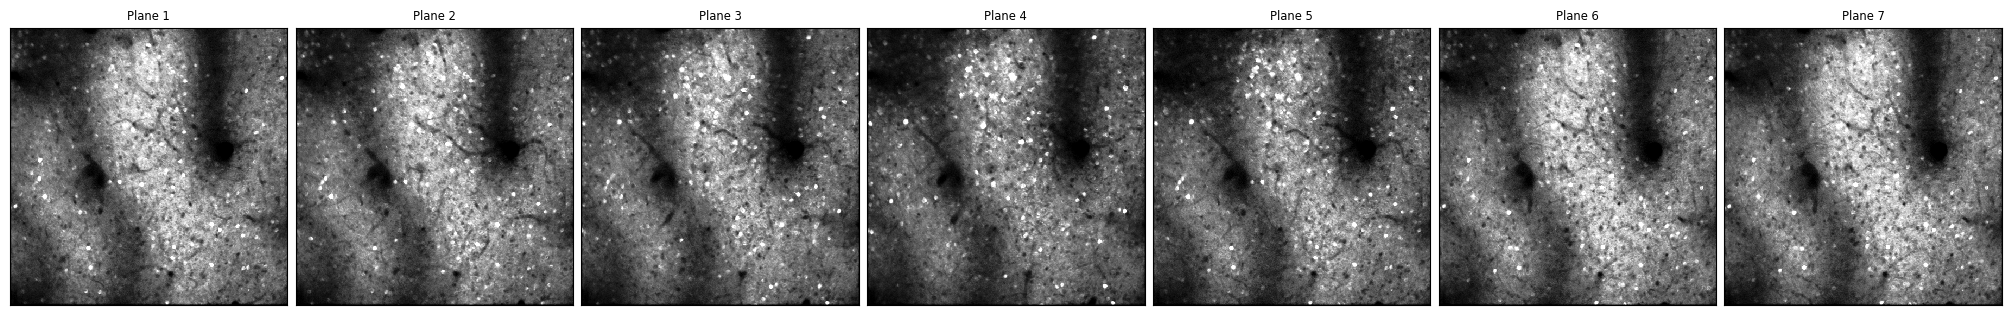

In [9]:
tfu.show_tif_all_planes(img3d, ncols=7, figsize=(20,5))

In [10]:
# nbui.ImageSliceViewer3D(img3d)

In [11]:
# %%time
# job.register(tifs=job.tifs)

In [12]:
mov = job.get_registered_movie()

In [ ]:

%%time
job.params['npil_filt_xy_um'] = 200
job.params['cell_filt_xy_um'] = 5.0
job.params['sdnorm_exp'] = 1.0
job.params['npil_filt_type'] = 'gaussian'
job.params['cell_filt_type'] = 'gaussian'
job.params['intensity_thresh'] = 1.0
corr_map = job.calculate_corr_map()

      Found dir /mnt/md0/runs/s3d-SS003_2024-08-15_1-2-3-4/corrmap
      Updating self.dirs tag corrmap
      Found dir /mnt/md0/runs/s3d-SS003_2024-08-15_1-2-3-4/mov_sub
      Updating self.dirs tag mov_sub
   Saved a copy of params at /mnt/md0/runs/s3d-SS003_2024-08-15_1-2-3-4/corrmap
   Updated main params file
   Computing correlation map of movie with 14224 frames, volume shape: 7, 512, 512
      Running batch 1 of 72
         Loading movie into shared memory
         Subtracting neuropil and applying cell filters
         Reducing filtered movie to compute correlation map
      Running batch 2 of 72
         Loading movie into shared memory
         Subtracting neuropil and applying cell filters
         Reducing filtered movie to compute correlation map
      Running batch 3 of 72
         Loading movie into shared memory
         Subtracting neuropil and applying cell filters
         Reducing filtered movie to compute correlation map
      Running batch 4 of 72
         Loadin

In [429]:
corr_map = job.load_corr_map_results()['vmap']

In [428]:
job.dirs['corrmap']

'/mnt/md0/runs/s3d-SS003_2024-08-15_1-2-3-4/corrmap'

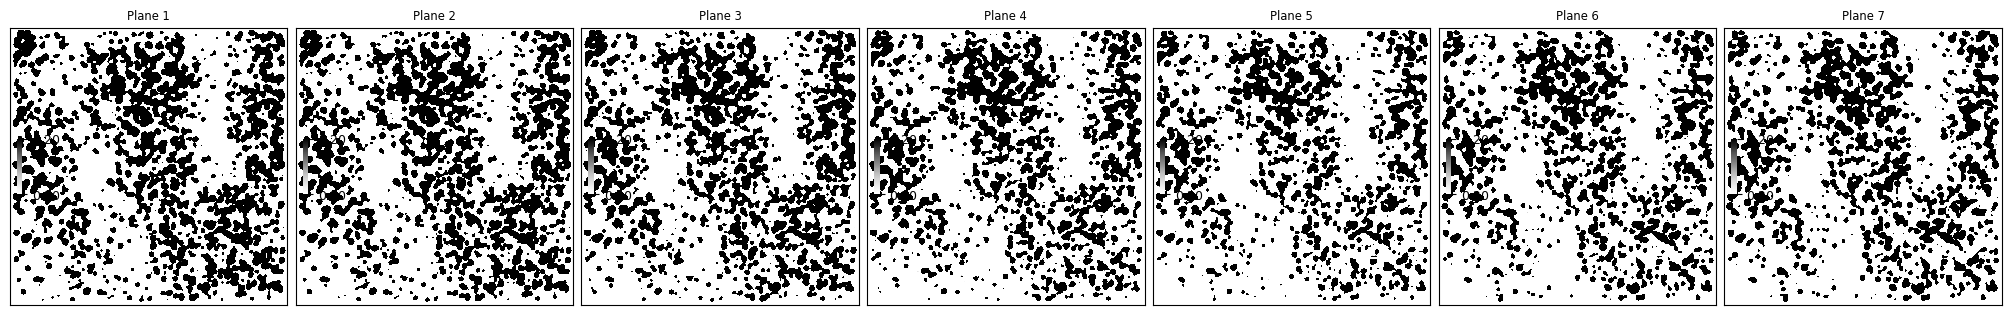

In [425]:
tfu.show_tif_all_planes(corr_map, ncols=7, figsize=(20,4),cbar=True, cmap='Greys', vminmax=(0.2,0.201))

In [95]:
from suite3d import extension as ext

In [311]:
from importlib import reload

In [329]:
# x0,x1 = 200, 400
# y0,y1 = 0, 200
# t0,t1 = 0, 1000
# corr_thresh = 0.5 
# patch = job.get_subtracted_movie()[t0:t1, :, y0:y1, x0:x1].compute()
# corr_map = job.load_corr_map_results()['vmap']
# cmap_patch = corr_map[:, y0:y1, x0:x1]
# cmap_patch_raw = cmap_patch.copy()

# reload(ext)
# patch_stats = ext.detect_cells_mp(patch, cmap_patch, n_proc_detect = 8, max_iter = 1000, peak_thresh = 0.3, activity_thresh = 5.0, percentile = 99.0,extend_thresh = 0.1, verbose=True)

In [344]:
%%time
job.params['peak_thresh'] = 0.15
# optionally, bin the movie in time to speed up detection
# probably a good idea if you have high framerate (>5 Hz?)
job.params['detection_timebin'] = 1 

# when extending an ROI, compare its activity to its neighboring pixels
# in frames where the fluorescence is above this percentile
job.params['percentile'] = 99.9

job.params['extend_thresh'] = 0.1
job.params['activity_thresh'] = 2.5
job.params['max_iter'] = 1000
job.params['ext_subtract_iters'] = 3

corr_map = job.load_corr_map_results()['vmap']
job.segment_rois(vmap=corr_map)

      Found dir /mnt/md0/runs/s3d-SS003_2024-08-15_1-2-3-4/segmentation
      Updating self.dirs tag segmentation
   Saved a copy of params at /mnt/md0/runs/s3d-SS003_2024-08-15_1-2-3-4/segmentation
   Updated main params file
      Found dir /mnt/md0/runs/s3d-SS003_2024-08-15_1-2-3-4/rois
      Updating self.dirs tag rois
   Saving results to /mnt/md0/runs/s3d-SS003_2024-08-15_1-2-3-4/segmentation and /mnt/md0/runs/s3d-SS003_2024-08-15_1-2-3-4/rois 
dict_keys(['max_img', 'mean_img', 'vmap', 'all_params'])
   Detecting from patch 1 / 36
      Found dir /mnt/md0/runs/s3d-SS003_2024-08-15_1-2-3-4/segmentation/patch-0000
         Loading 5.34 GB movie to memory, shape: (14224, 7, 120, 120) 
         Loaded
         Loading movie patch to shared memory
         Loaded
      Starting extraction with peak_thresh: 0.150 and Th2: 2.500
         Iter 0000: running 16 ROIs in parallel
         Added cell 1 at 00, 053, 013, peak: 0.955, thresh: 2.500, 2880 frames, 724 pixels
         Added cell 2

'/mnt/md0/runs/s3d-SS003_2024-08-15_1-2-3-4/rois'

In [346]:
len(seg['stats'])

3804

In [ ]:
job.

In [420]:
job.params['tau']

1.3

In [423]:
seg['info'].keys()

dict_keys(['max_img', 'mean_img', 'vmap', 'all_params'])

In [345]:
seg = job.load_segmentation_results()
shape = seg['info']['vmap'].shape
cell_id_vol, rgb_vol = ui.make_label_vols(seg['stats'], shape, lam_max=0.1, cmap='Set1')

nbui.ImageSliceViewer3D(seg['info']['vmap'],cmap='Greys',vminmax=(0,0.5), overlay=rgb_vol, alpha=1.0)

      Loading from /mnt/md0/runs/s3d-SS003_2024-08-15_1-2-3-4/rois/info.npy
      Loading from /mnt/md0/runs/s3d-SS003_2024-08-15_1-2-3-4/rois/stats.npy
      Loading from /mnt/md0/runs/s3d-SS003_2024-08-15_1-2-3-4/rois/iscell.npy


interactive(children=(RadioButtons(description='Slice plane selection:', options=('x-y', 'y-z', 'z-x'), style=…

In [347]:
job.compute_npil_masks(stats_dir = job.dirs['rois'])



traces = job.extract_and_deconvolve(stats_dir=job.dirs['rois'])

job.export_results('/mnt/zeytin-f1/s3d-results/',result_dir_name='rois')

   Updated main params file
   Movie shape: (7, 14224, 512, 512)
3804
   Extracting 3804 valid cells, and saving cell flags to /mnt/md0/runs/s3d-SS003_2024-08-15_1-2-3-4/rois/iscell_extracted.npy
   Extracting activity
         Will extract in 29 batches of 500
Saving intermediate results to /mnt/md0/runs/s3d-SS003_2024-08-15_1-2-3-4/rois
            Extracting batch 0000 of 0029
            Batch size: 3 GB
            Extracting batch 0001 of 0029
            Batch size: 3 GB
            Extracting batch 0002 of 0029
            Batch size: 3 GB
            Extracting batch 0003 of 0029
            Batch size: 3 GB
            Extracting batch 0004 of 0029
            Batch size: 3 GB
            Extracting batch 0005 of 0029
            Batch size: 3 GB
            Extracting batch 0006 of 0029
            Batch size: 3 GB
            Extracting batch 0007 of 0029
            Batch size: 3 GB
            Extracting batch 0008 of 0029
            Batch size: 3 GB
            Extracti

In [418]:
# roi_idx = 108

# medx = seg['stats'][roi_idx]['med']
# zz,yy,xx = seg['stats'][roi_idx]['coords']
# lam = seg['stats'][roi_idx]['lam']

# mov = job.get_registered_movie()

# mov_snip = n.load(job.get_registered_files()[0])

# roi_pix_fs = mov_snip[zz,:,yy,xx]

# mov_roi_fs = ((lam / lam.sum()) @ roi_pix_fs)

# med_trace = mov[medx[0], :, medx[1]-2:medx[1]+2, medx[2]-2:medx[2]+2].compute().reshape(-1,16)


# plt.plot(traces['F'][roi_idx][0:100])
# plt.plot(mov_roi_fs)
# plt.plot(med_trace.mean(axis=-1))
# plt.xlim(0,100)

# plt.plot(med_trace.mean(axis=-1), alpha=0.5)
# plt.plot(traces['F'][roi_idx][:], alpha=0.5)
# plt.xlim(2750,2800)

